In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
np.random.seed(1)
# Generating training data
x1 = np.random.uniform(7, size=100).round(2)
x2 = np.random.uniform(7, size=100).round(2)
x3 = np.random.uniform(-7, 0, size=100).round(2)
x4 = np.random.uniform(-7, 0, size=100).round(2)

dataset_0_0 = pd.DataFrame({'x1': x1[ : 50], 'x2': x2[ : 50], 'y': [0]*50})
dataset_0_1 = pd.DataFrame({'x1': x1[50 : ], 'x2': x4[ : 50], 'y': [1]*50})
dataset_1_0 = pd.DataFrame({'x1': x3[ : 50], 'x2': x2[50 : ], 'y': [1]*50})
dataset_1_1 = pd.DataFrame({'x1': x3[50 : ], 'x2': x4[50 : ], 'y': [0]*50})

train_data = pd.concat([dataset_0_0, dataset_0_1, dataset_1_0, dataset_1_1])
train_data

,x1,x2,y
0,4.50,5.04,0
1,2.68,3.84,0
2,7.00,1.68,0
3,5.19,4.86,0
4,6.12,1.55,0
...,...,...,...
45,-6.52,-1.09,0
46,-4.35,-4.33,0
47,-6.44,-1.75,0
48,-0.12,-3.42,0


<function matplotlib.pyplot.show(close=None, block=None)>

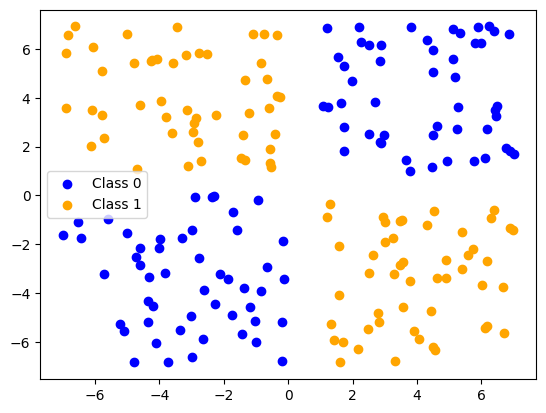

In [65]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(train_data['x1'][train_data['y'] == 0], train_data['x2'][train_data['y'] == 0], color = 'blue', label='Class 0')
ax.scatter(train_data['x1'][train_data['y'] == 1], train_data['x2'][train_data['y'] == 1], color = 'orange', label='Class 1')
ax.legend()
plt.show

In [66]:
np.random.seed(20)
# Generating test data
x1 = np.random.uniform(7, size=100).round(2)
x2 = np.random.uniform(7, size=100).round(2)
x3 = np.random.uniform(-7, 0, size=100).round(2)
x4 = np.random.uniform(-7, 0, size=100).round(2)

dataset_0_0 = pd.DataFrame({'x1': x1[ : 50], 'x2': x2[ : 50], 'y1': [0]*50})
dataset_0_1 = pd.DataFrame({'x1': x1[50 : ], 'x2': x4[ : 50], 'y1': [1]*50})
dataset_1_0 = pd.DataFrame({'x1': x3[ : 50], 'x2': x2[50 : ], 'y1': [1]*50})
dataset_1_1 = pd.DataFrame({'x1': x3[50 : ], 'x2': x4[50 : ], 'y1': [0]*50})

test_data = pd.concat([dataset_0_0, dataset_0_1, dataset_1_0, dataset_1_1])

<function matplotlib.pyplot.show(close=None, block=None)>

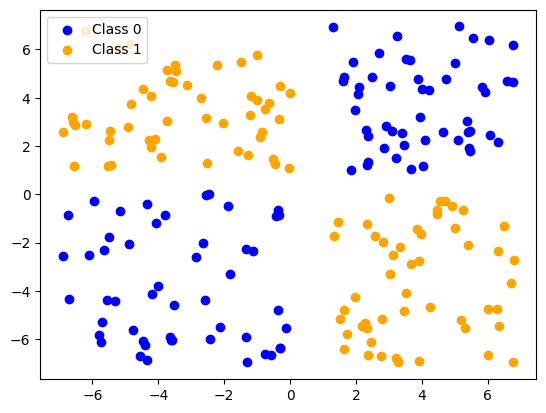

In [67]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(test_data['x1'][test_data['y1'] == 0], test_data['x2'][test_data['y1'] == 0], color = 'blue', label='Class 0')
ax.scatter(test_data['x1'][test_data['y1'] == 1], test_data['x2'][test_data['y1'] == 1], color = 'orange', label='Class 1')
ax.legend()
plt.show

In [68]:
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [69]:
# Shuffle train and test data
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [70]:
# Define features and target variable
X_train = train_data[['x1', 'x2']].values.astype(np.float32)
y_train = train_data['y'].values.reshape(-1, 1).astype(np.float32)
X_test = test_data[['x1', 'x2']].values.astype(np.float32)
y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)

In [71]:
# Create DataLoader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

## MLP

In [72]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [73]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)
model

MLP(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [74]:
# baseline accuracy and loss
accuracy, train_loss = 0, 0
for inputs, labels in train_loader:
    outputs = model(inputs)
    predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
    accuracy += torch.sum(predicted_labels == labels)
    loss = criterion(outputs, labels)
    train_loss += loss.item() 

print(f'Baseline accuracy {accuracy / len(train_loader.dataset)}, Baseline loss {train_loss/len(train_loader)}')

Baseline accuracy 0.5299999713897705, Baseline loss 0.6976538300514221


In [75]:
# Training loop
epochs = 1000
train_losses = []
for epoch in range(epochs):
    train_loss = 0.0
    accuracy = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(predicted_labels == labels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() 
    
    if epoch % 100 ==0:
        print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f} loss {train_loss/len(train_loader):.4f}')

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
total_train_loss = np.mean(train_losses)
print(f'Training loss: {total_train_loss:.4f}')

Epoch 0 Accuracy 0.5300 loss 0.6977


Epoch 100 Accuracy 1.0000 loss 0.1989
Epoch 200 Accuracy 1.0000 loss 0.1065
Epoch 300 Accuracy 0.9950 loss 0.0774
Epoch 400 Accuracy 0.9950 loss 0.0620
Epoch 500 Accuracy 0.9950 loss 0.0523
Epoch 600 Accuracy 0.9950 loss 0.0453
Epoch 700 Accuracy 1.0000 loss 0.0400
Epoch 800 Accuracy 1.0000 loss 0.0358
Epoch 900 Accuracy 1.0000 loss 0.0323
Training loss: 0.0981


In [76]:
# MLP on test_data
test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(predicted_labels == labels)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
print(f'Test loss: {test_loss/len(test_loader):.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.0412, accuracy: 0.9900


In [77]:
input = torch.tensor([0.48, -0.15])
output = model(input)
print(output)

tensor([0.7653], grad_fn=<SigmoidBackward0>)


In [78]:
# Create meshgrid data for visualization
xx = torch.arange(-7.0, 8.0).clone().detach()
yy = torch.arange(-7.0, 8.0).clone().detach()
xx, yy = torch.meshgrid(xx, yy)

# Flatten meshgrid data
xx1 = xx.reshape(-1, 1)
yy1 = yy.reshape(-1, 1)

# Combine xx1 and yy1 to create input data
data = torch.hstack([xx1, yy1])

# Get predictions from the model
z = model(data)

# Threshold predictions to get binary values
z = torch.where(z > 0.5, 1, 0)

# Reshape z to match the meshgrid dimensions
z = z.reshape(15, 15)


#### Decision surface of MLP 

<function matplotlib.pyplot.show(close=None, block=None)>

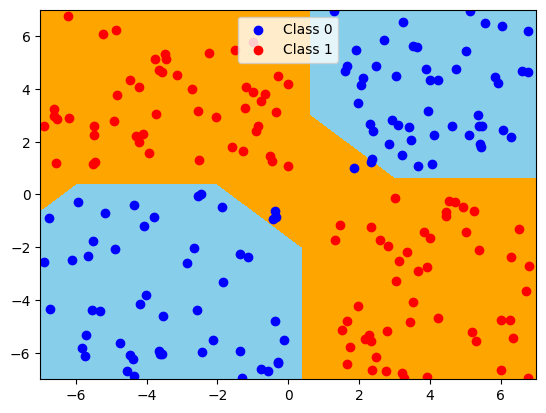

In [79]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue', label='Class 0')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red', label='Class 1')
ax.legend()
plt.show

## MLP with L1 Regularisation

In [80]:
def create_train_val_loader(train_data, i, block_size, batch_size_train=200, batch_size_val=40):
    start = i * block_size
    end = start + block_size

    val_dataset = train_data[start:end].reset_index(drop=True)
    X_val = val_dataset[['x1', 'x2']].values.astype(np.float32)
    y_val = val_dataset['y'].values.reshape(-1, 1).astype(np.float32)
    val_dataset = CustomDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    Xy_train = pd.concat([train_data[:start], train_data[end:]], axis=0).reset_index(drop=True)
    X_train = Xy_train[['x1', 'x2']].values.astype(np.float32)
    y_train = Xy_train['y'].values.reshape(-1, 1).astype(np.float32)
    train_dataset = CustomDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

    return train_loader, val_loader

In [81]:
# 5-fold cross validation
K = 5
epochs = 1000
block = len(train_data) // K
valid_loss_acc = {}

for learning_rate in [0.0001, 0.001, 0.01, 0.1, 1]:
    for regularization_coefficient in [0.0001, 0.001, 0.01, 0.1, 1]:
        k_cross_val_loss = []
        k_cross_val_acc = []
        for i in range(K):
            #  Splitting Train into Train and Validation Dataset
            train_loader, val_loader = create_train_val_loader(train_data, i,block)

            # Initialize MLP
            model = MLP(input_size=2, hidden_size=4)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training the model
            train_losses = []
            for epoch in range(epochs):
                train_loss = 0.0
                accuracy = 0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    predicted_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(predicted_labels == labels)
                    loss = criterion(outputs, labels)

                    sum = 0
                    for params in model.parameters():
                        params = params.view(-1)
                        sum += torch.sum(torch.abs(params))  # L1 regularization term

                    loss += regularization_coefficient * sum
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() 
                
                if epoch % 100 == 0:
                    print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f}')

                train_loss /= len(train_loader)
                train_losses.append(train_loss)
                
            total_train_loss = np.mean(train_losses)
            print(f'In {i+1} Cross validation,for {learning_rate}_{regularization_coefficient} Training loss: {total_train_loss:.4f}')

            # Validation
            val_loss = 0.0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:    
                    outputs = model(inputs)
                    predicted_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(predicted_labels == labels)

                    loss = criterion(outputs, labels)
                    for params in model.parameters():
                        params = params.view(-1)
                        sum += torch.sum(torch.abs(params))  # L1 regularization term
                    loss += regularization_coefficient * sum

                    val_loss += loss.item()

            k_cross_val_loss.append(val_loss/len(val_loader))
            k_cross_val_acc.append(accuracy/len(val_loader.dataset))
            print(f'Validation loss: {val_loss/len(val_loader):.4f}, Validation accuracy: {accuracy/len(val_loader.dataset):.4f}')

        valid_loss_acc[f'{learning_rate}_{regularization_coefficient}_loss'] = np.mean(k_cross_val_loss)
        valid_loss_acc[f'{learning_rate}_{regularization_coefficient}_acc'] = np.mean(k_cross_val_acc)


Epoch 0 Accuracy 0.5188
Epoch 100 Accuracy 0.5125
Epoch 200 Accuracy 0.5125
Epoch 300 Accuracy 0.5125
Epoch 400 Accuracy 0.5063
Epoch 500 Accuracy 0.5000
Epoch 600 Accuracy 0.4875
Epoch 700 Accuracy 0.4812
Epoch 800 Accuracy 0.4812
Epoch 900 Accuracy 0.4812
In 1 Cross validation,for 0.0001_0.0001 Training loss: 0.6955
Validation loss: 0.6895, Validation accuracy: 0.5250
Epoch 0 Accuracy 0.5063
Epoch 100 Accuracy 0.5063
Epoch 200 Accuracy 0.5063
Epoch 300 Accuracy 0.5063
Epoch 400 Accuracy 0.5063
Epoch 500 Accuracy 0.5063
Epoch 600 Accuracy 0.5063
Epoch 700 Accuracy 0.5063
Epoch 800 Accuracy 0.5063
Epoch 900 Accuracy 0.5063
In 2 Cross validation,for 0.0001_0.0001 Training loss: 0.7370
Validation loss: 0.7306, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.6438
Epoch 100 Accuracy 0.6313
Epoch 200 Accuracy 0.6250
Epoch 300 Accuracy 0.6000
Epoch 400 Accuracy 0.6000
Epoch 500 Accuracy 0.5938
Epoch 600 Accuracy 0.5938
Epoch 700 Accuracy 0.5938
Epoch 800 Accuracy 0.5813
Epoch 900 Accuracy 0.5

In [85]:
t = pd.DataFrame(valid_loss_acc, index = ['val']).T
t['val'] = t['val'].apply(lambda x: round(x, 2))
t

,val
0.0001_0.0001_loss,0.71
0.0001_0.0001_acc,0.51
0.0001_0.001_loss,0.70
0.0001_0.001_acc,0.52
0.0001_0.01_loss,0.78
0.0001_0.01_acc,0.50
0.0001_0.1_loss,1.52
0.0001_0.1_acc,0.59
0.0001_1_loss,8.83
0.0001_1_acc,0.53


In [88]:
best_params = t.idxmin()  # Find the hyperparameters that minimize the validation loss
best_loss = t.min()  # Get the minimum validation loss
best_accuracy = t.loc[best_params, 'val']  # Get the accuracy corresponding to the best parameters

# Extract learning rate and regularization coefficient as floats
learning_rate = float(best_params['val'].split('_')[0])
regularization_coefficient = float(best_params['val'].split('_')[1])
validation_loss = best_loss['val']
validation_accuracy = best_accuracy

print("Best Hyperparameters (Minimize Validation Loss):")
print("Learning Rate:", learning_rate)
print("Regularization coefficient:", regularization_coefficient)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)


Best Hyperparameters (Minimize Validation Loss):
Learning Rate: 0.1
Regularization coefficient: 0.001
Validation Loss: 0.26
Validation Accuracy: 0.1_0.001_loss    0.26
Name: val, dtype: float64


In [89]:
model = MLP(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# regularization_coefficient = 0.001

# training the model
epochs = 1000
train_losses = []
for epoch in range(epochs):
    train_loss = 0.0
    accuracy = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        sum = 0
        for params in model.parameters():
            params = params.view(-1)
            sum += torch.sum(torch.abs(params))

        loss += regularization_coefficient * sum
        loss.backward()
        optimizer.step()

        train_loss += loss.item() 
    
    if epoch % 100 ==0:
        print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f} loss {train_loss/len(train_loader):.4f}')

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
total_train_loss = np.mean(train_losses)
print(f'Training loss: {total_train_loss:.4f}')

        

Epoch 0 Accuracy 0.0000 loss 0.7540
Epoch 100 Accuracy 0.0000 loss 0.1882
Epoch 200 Accuracy 0.0000 loss 0.1553
Epoch 300 Accuracy 0.0000 loss 0.1451
Epoch 400 Accuracy 0.0000 loss 0.1400
Epoch 500 Accuracy 0.0000 loss 0.1371
Epoch 600 Accuracy 0.0000 loss 0.1354
Epoch 700 Accuracy 0.0000 loss 0.1342
Epoch 800 Accuracy 0.0000 loss 0.1335
Epoch 900 Accuracy 0.0000 loss 0.1330
Training loss: 0.1677


In [90]:
# X_test = test_data[['x1', 'x2']].values.astype(np.float32)
# y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)
# test_dataset = CustomDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(predicted_labels == labels)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test loss: {test_loss:.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.0761, accuracy: 0.9700


In [91]:
# Generating a grid of points for evaluation
x_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
y_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
x_values, y_values = torch.meshgrid(x_values, y_values)
x_values = x_values.reshape(-1, 1)
y_values = y_values.reshape(-1, 1)
grid_data = torch.hstack([x_values, y_values])

# Evaluating the model on the grid
model_outputs = model(grid_data)

# Thresholding the model outputs
thresholded_outputs = torch.where(model_outputs > 0.5, 1, 0)

# Reshaping the thresholded outputs into a 2D grid
z = thresholded_outputs.reshape(15, 15)

C:\Users\prash\AppData\Local\Temp\ipykernel_4140\2695446099.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
C:\Users\prash\AppData\Local\Temp\ipykernel_4140\2695446099.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)


#### Decision surface of MLP with L1 Regularisation

<function matplotlib.pyplot.show(close=None, block=None)>

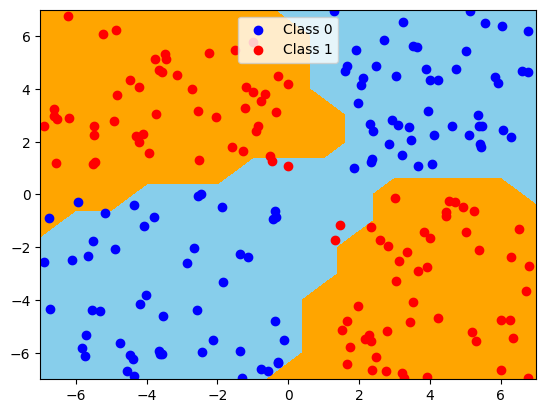

In [92]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue',label='Class 0')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red', label='Class 1')
ax.legend()
plt.show

## MLP with L2 Regularisation

In [93]:
# 5-fold cross validation
K = 5
epochs = 1000
block = len(train_data) // K
valid_loss_acc = {}

for learning_rate in [0.0001, 0.001, 0.01, 0.1, 1]:
    for regularization_coefficient in [0.0001, 0.001, 0.01, 0.1, 1]:
        k_cross_val_loss = []
        k_cross_val_acc = []
        for i in range(K):
            #  Splitting Train into Train and Validation Dataset
            train_loader, val_loader = create_train_val_loader(train_data, i, block)

            # Initialize MLP
            model = MLP(input_size=2, hidden_size=4)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training the model
            train_losses = []
            for epoch in range(epochs):
                train_loss = 0.0
                accuracy = 0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    predicted_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(predicted_labels == labels)
                    loss = criterion(outputs, labels)

                    sum = 0
                    for params in model.parameters():
                        sum += torch.sum(torch.square(params))  # L2 regularization term

                    loss += regularization_coefficient * sum
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() 
                
                if epoch % 100 == 0:
                    print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f}')

                train_loss /= len(train_loader)
                train_losses.append(train_loss)
                
            total_train_loss = np.mean(train_losses)
            print(f'In {i+1} Cross validation,for {learning_rate}_{regularization_coefficient} Training loss: {total_train_loss:.4f}')

            # Validation
            val_loss = 0.0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:    
                    outputs = model(inputs)
                    predicted_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(predicted_labels == labels)

                    loss = criterion(outputs, labels)
                    for params in model.parameters():
                        sum += torch.sum(torch.square(params))  # L2 regularization term
                    loss += regularization_coefficient * sum

                    val_loss += loss.item()

            k_cross_val_loss.append(val_loss/len(val_loader))
            k_cross_val_acc.append(accuracy/len(val_loader.dataset))
            print(f'Validation loss: {val_loss/len(val_loader):.4f}, Validation accuracy: {accuracy/len(val_loader.dataset):.4f}')

        valid_loss_acc[f'{learning_rate}_{regularization_coefficient}_loss'] = np.mean(k_cross_val_loss)
        valid_loss_acc[f'{learning_rate}_{regularization_coefficient}_acc'] = np.mean(k_cross_val_acc)


Epoch 0 Accuracy 0.5063
Epoch 100 Accuracy 0.5063
Epoch 200 Accuracy 0.5063
Epoch 300 Accuracy 0.5063
Epoch 400 Accuracy 0.5063
Epoch 500 Accuracy 0.5063
Epoch 600 Accuracy 0.5063
Epoch 700 Accuracy 0.5063
Epoch 800 Accuracy 0.5063
Epoch 900 Accuracy 0.5063
In 1 Cross validation,for 0.0001_0.0001 Training loss: 0.6995
Validation loss: 0.6978, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.4938
Epoch 100 Accuracy 0.4938
Epoch 200 Accuracy 0.4938
Epoch 300 Accuracy 0.4938
Epoch 400 Accuracy 0.4812
Epoch 500 Accuracy 0.4688
Epoch 600 Accuracy 0.4750
Epoch 700 Accuracy 0.4938
Epoch 800 Accuracy 0.4812
Epoch 900 Accuracy 0.4625
In 2 Cross validation,for 0.0001_0.0001 Training loss: 0.7016
Validation loss: 0.6915, Validation accuracy: 0.5500
Epoch 0 Accuracy 0.4812
Epoch 100 Accuracy 0.4812
Epoch 200 Accuracy 0.4812
Epoch 300 Accuracy 0.4812
Epoch 400 Accuracy 0.4688
Epoch 500 Accuracy 0.4437
Epoch 600 Accuracy 0.4375
Epoch 700 Accuracy 0.4062
Epoch 800 Accuracy 0.4000
Epoch 900 Accuracy 0.3

In [94]:
t = pd.DataFrame(valid_loss_acc, index = ['val']).T
t['val'] = t['val'].apply(lambda x: round(x, 2))
t

,val
0.0001_0.0001_loss,0.70
0.0001_0.0001_acc,0.47
0.0001_0.001_loss,0.70
0.0001_0.001_acc,0.47
0.0001_0.01_loss,0.74
0.0001_0.01_acc,0.40
0.0001_0.1_loss,0.96
0.0001_0.1_acc,0.49
0.0001_1_loss,4.21
0.0001_1_acc,0.52


In [95]:
best_params = t.idxmin()  # Find the hyperparameters that minimize the validation loss
best_loss = t.min()  # Get the minimum validation loss
best_accuracy = t.loc[best_params, 'val']  # Get the accuracy corresponding to the best parameters

# Extract learning rate and regularization coefficient as floats
learning_rate = float(best_params['val'].split('_')[0])
regularization_coefficient = float(best_params['val'].split('_')[1])
validation_loss = best_loss['val']
validation_accuracy = best_accuracy

print("Best Hyperparameters (Minimize Validation Loss):")
print("Learning Rate:", learning_rate)
print("Regularization coefficient:", regularization_coefficient)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)


Best Hyperparameters (Minimize Validation Loss):
Learning Rate: 0.01
Regularization coefficient: 0.0001
Validation Loss: 0.21
Validation Accuracy: 0.01_0.0001_loss    0.21
Name: val, dtype: float64


In [100]:
model = MLP(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# regularization_coefficient = 0.001

# training the model
epochs =2000
train_losses = []
for epoch in range(epochs):
    train_loss = 0.0
    accuracy = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        sum = 0
        for params in model.parameters():
            sum += torch.sum(torch.square(params))

        loss += regularization_coefficient * sum
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
    
    if epoch % 100 ==0:
        print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f} loss {train_loss/len(train_loader):.4f}')

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
total_train_loss = np.mean(train_losses)
print(f'Training loss: {total_train_loss:.4f}')
        

Epoch 0 Accuracy 0.0000 loss 0.7134
Epoch 100 Accuracy 0.0000 loss 0.5584
Epoch 200 Accuracy 0.0000 loss 0.3886
Epoch 300 Accuracy 0.0000 loss 0.3177
Epoch 400 Accuracy 0.0000 loss 0.2909
Epoch 500 Accuracy 0.0000 loss 0.2793
Epoch 600 Accuracy 0.0000 loss 0.2736
Epoch 700 Accuracy 0.0000 loss 0.2696
Epoch 800 Accuracy 0.0000 loss 0.2660
Epoch 900 Accuracy 0.0000 loss 0.2616
Epoch 1000 Accuracy 0.0000 loss 0.2383
Epoch 1100 Accuracy 0.0000 loss 0.2309
Epoch 1200 Accuracy 0.0000 loss 0.2262
Epoch 1300 Accuracy 0.0000 loss 0.2230
Epoch 1400 Accuracy 0.0000 loss 0.2207
Epoch 1500 Accuracy 0.0000 loss 0.2192
Epoch 1600 Accuracy 0.0000 loss 0.2180
Epoch 1700 Accuracy 0.0000 loss 0.2172
Epoch 1800 Accuracy 0.0000 loss 0.2166
Epoch 1900 Accuracy 0.0000 loss 0.2162
Training loss: 0.2796


In [101]:
# X_test = test_data[['x1', 'x2']].values.astype(np.float32)
# y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)
# test_dataset = CustomDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(predicted_labels == labels)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test loss: {test_loss:.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.2427, accuracy: 0.9250


In [103]:
# Generating a grid of points for evaluation
x_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
y_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
x_values, y_values = torch.meshgrid(x_values, y_values)
x_values = x_values.reshape(-1, 1)
y_values = y_values.reshape(-1, 1)
grid_data = torch.hstack([x_values, y_values])

# Evaluating the model on the grid
model_outputs = model(grid_data)

# Thresholding the model outputs
thresholded_outputs = torch.where(model_outputs > 0.5, 1, 0)

# Reshaping the thresholded outputs into a 2D grid
z = thresholded_outputs.reshape(15, 15)

C:\Users\prash\AppData\Local\Temp\ipykernel_4140\2695446099.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
C:\Users\prash\AppData\Local\Temp\ipykernel_4140\2695446099.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)


#### Decision surface of MLP with L2 Regularisation

<function matplotlib.pyplot.show(close=None, block=None)>

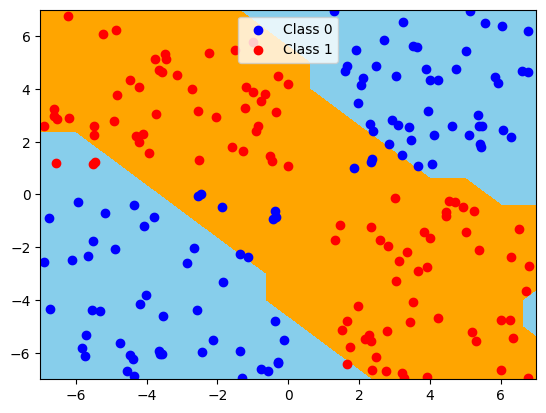

In [104]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue', label='Class 0')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red', label='Class 1')
ax.legend()
plt.show

## Logistic Regression Model

In [130]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits = self.linear(x)
        return logits

In [131]:
# Shuffle train and test data
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

### With x1^2

In [146]:
X_train = pd.concat([train_data['x1'], train_data['x2'], train_data['x1']**2], axis = 1)
X_train.columns = ['x1','x2','x1^2']
X_train = torch.tensor(X_train.values, dtype= torch.float32)
y_train = train_data['y']
y_train = torch.tensor(y_train.values, dtype= torch.float32)
# y_train

In [147]:
reg = LogisticRegression(3)
optimizer = torch.optim.Adam(reg.parameters(), lr=0.01)
converged = False

prev_loss = 1e8

i = 0
while not converged:
    optimizer.zero_grad()
    logits = reg(X_train)
    logits = logits.reshape(-1)
    # print(logits)
    loss = F.binary_cross_entropy_with_logits(logits, y_train)
    loss.backward()
    optimizer.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1


pred = F.sigmoid(reg(X_train))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_train = y_train.reshape(-1, 1)
correct_pred = torch.sum(pred == y_train)
acc = correct_pred / len(y_train)
print(f'Training accuracy using Logistic Regression with sqaure of x1 {acc}')

0 1.744828701019287
10 0.9758973717689514
20 0.7313200235366821
30 0.7270767092704773
40 0.6997866034507751
50 0.6957713961601257
60 0.6950086355209351
70 0.6929523944854736
Training accuracy using Logistic Regression with sqaure of x1 0.4950000047683716


In [148]:
X_test = pd.concat([test_data['x1'], test_data['x2'], test_data['x1']**2], axis = 1)
X_test.columns = ['x1','x2','x1^2']
X_test = torch.tensor(X_test.values, dtype= torch.float32)
y_test = test_data['y1']
y_test = torch.tensor(y_test.values, dtype= torch.float32)


pred = F.sigmoid(reg(X_test))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_test = y_test.reshape(-1, 1)
correct_pred = torch.sum(pred == y_test)
acc = correct_pred / len(y_test)
print(f'Testing accuracy using Logistic Regression with sqaure of x1 {acc}')

Testing accuracy using Logistic Regression with sqaure of x1 0.5199999809265137


In [151]:
xx1 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
xx3 = xx1*xx1
# print(xx3)
data = torch.hstack([xx1, xx2, xx3 ])
z = reg(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(15,15)

C:\Users\prash\AppData\Local\Temp\ipykernel_4140\4244722955.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
C:\Users\prash\AppData\Local\Temp\ipykernel_4140\4244722955.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)


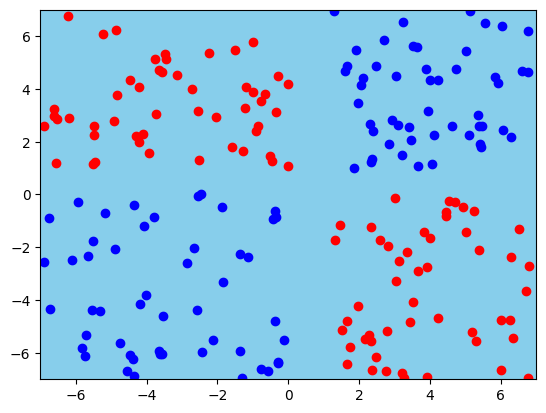

In [150]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')

### With x1x2

In [140]:
X_train = pd.concat([train_data['x1'], train_data['x2'], train_data['x1']*train_data['x2']], axis = 1)
X_train.columns = ['x1','x2','x1x2']
X_train = torch.tensor(X_train.values, dtype= torch.float32)
y_train = train_data['y']
y_train = torch.tensor(y_train.values, dtype= torch.float32)

In [141]:
reg = LogisticRegression(3)
opt = torch.optim.Adam(reg.parameters(), lr=0.01)
converged = False

prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = reg(X_train)
    logits = logits.reshape(-1)
    loss = F.binary_cross_entropy_with_logits(logits, y_train)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

pred = F.sigmoid(reg(X_train))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_train = y_train.reshape(-1, 1)
correct_pred = torch.sum(pred == y_train)
acc = correct_pred / len(y_train)
print(f'Training accuracy using Logistic Regression with x1x2 {acc}')

0 7.0475568771362305
10 5.696450233459473
20 4.369565963745117
30 3.0910232067108154
40 1.8935534954071045
50 0.914426863193512
60 0.4469161629676819
70 0.3069368600845337
80 0.25247180461883545
90 0.22390516102313995
100 0.20553576946258545
110 0.19197456538677216
120 0.181035578250885
130 0.17178188264369965
140 0.1637328565120697
150 0.1566079556941986
160 0.15022698044776917
170 0.14446263015270233
180 0.13921906054019928
190 0.13442160189151764
200 0.13001033663749695
210 0.1259363293647766
220 0.12215907126665115
230 0.118644580245018
240 0.11536417156457901
250 0.11229334026575089
260 0.10941100865602493
270 0.10669898986816406
280 0.10414143651723862
290 0.10172447562217712
300 0.09943590313196182
310 0.09726496785879135
320 0.09520211815834045
330 0.09323885291814804
340 0.09136752039194107
350 0.08958132565021515
360 0.0878741517663002
370 0.08624039590358734
380 0.08467508107423782
390 0.08317361772060394
400 0.0817318931221962
410 0.08034607768058777
420 0.07901275902986526

In [142]:
X_test = pd.concat([test_data['x1'], test_data['x2'], test_data['x1']*test_data['x2']], axis = 1)
X_test.columns = ['x1','x2','x1x2']
X_test = torch.tensor(X_test.values, dtype= torch.float32)
y_test = test_data['y1']
y_test = torch.tensor(y_test.values, dtype= torch.float32)

pred = F.sigmoid(reg(X_test))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_test = y_test.reshape(-1, 1)
correct_pred = torch.sum(pred == y_test)
acc = correct_pred / len(y_test)
print(f'Testing accuracy using Logistic Regression {acc}')

Testing accuracy using Logistic Regression 1.0


In [143]:
xx1 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
xx3 = xx1 * xx2
data = torch.hstack([xx1, xx2, xx3 ])
z = reg(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(15,15)

C:\Users\prash\AppData\Local\Temp\ipykernel_4140\2389335295.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
C:\Users\prash\AppData\Local\Temp\ipykernel_4140\2389335295.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)


#### Decision surface of Logistic regression

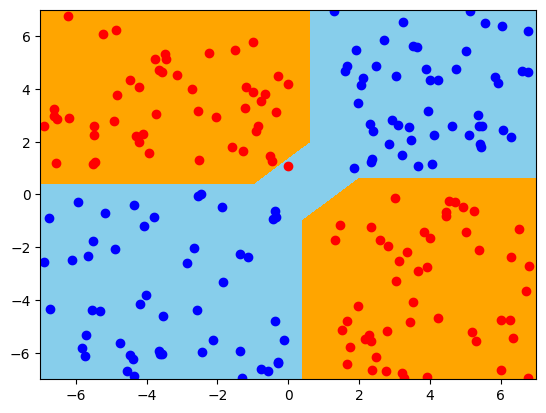

In [144]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')